# Map of domains for calculating ocean modes and proxy locations

Figure 2. a) Spatial domains used for the calculation of the TPI (characterizing IPO variability) and the N3.4 index and b) networks of paleoclimate and IAEA δ¹⁸O records over the SASM domain. Color shading in b) represents the percent of water year (July – June) precipitation falling during the austral summer (DJF) period (GPCP, 1979 – 2019 CE). Vectors in b) show the low-level wind field (850 hPa; ERA5, 1979 – 2020 CE). Symbols in b) indicate different archive types (cross: speleothem; diamond: ice core; circle: lake core; triangle: tree-ring core; and square: IAEA station) and mark the approximate locations of IAEA stations and paleoclimate records used for the IPO analysis (indicated with purple color) and ENSO analysis (indicated with orange color). Pumacocha, P00-H1, and CR1 records are shifted slightly for better visibility. 

In [1]:
# Load all funcs
#numerical computation
import numpy as np
import copy as cp 
import glob
import pandas as pd
import xarray as xr
import os.path
from eofs.xarray import Eof
import netCDF4
from scipy import signal
from scipy import ndimage
from scipy import stats
from sklearn import decomposition
# from sklearn.decomposition import pca
from sklearn import preprocessing
#from statsmodels.multivariate.pca import PCA   # this is more of a climate perspective on PCA

#plotting
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cf
import matplotlib as mpl
import matplotlib.colors as cls
# from matplotlib.colors import DivergingNorm
from matplotlib.gridspec import GridSpec
from matplotlib.image import imread
import matplotlib.patches as patches
from matplotlib.lines import Line2D   
import matplotlib.patheffects as PathEffects
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker

plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 12})

%matplotlib inline 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import proplot as plot
import seaborn as sns
import shapely.geometry as sgeom
# -------------------------- Plotting specs

# plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 12})

# -------------------------- Functions
def geo_loc(target,array):
    return array[np.abs(array - target).argmin()]

# -------------------------- suppress warnings to keep plotting organized
import warnings 
warnings.filterwarnings("ignore")

In [13]:
# Load data
#Data for plotting:
#---------------
# GPCP DATA (precip, land and ocean): 
#---------------
path = "/network/rit/home/ro553136/orrison/data/observations/GPCP/"
fh = xr.open_dataset(path + 'precip.DJFfracAnn_forplotting.nc')
djf_frac_avg = fh.P
lon = fh.lon
lat = fh.lat

# Era5 reanalysis:
path = "/network/rit/home/ro553136/orrison/data/reanalysis/era5/"
fhu_l = xr.open_dataset(path + 'era5_u_DJF_1979_2020_forplotting.nc')
fhv_l = xr.open_dataset(path + 'era5_v_DJF_1979_2020_forplotting.nc')
u = fhu_l.U
v = fhv_l.V
lat_U = fhu_l.latitude
lon_U = fhu_l.longitude

# lists for ipo
recs_ipo = ['P00-H1', 'CR1', 'JAR4', 'SBE3', 'DV2+TR5\n+LD12', 'PIM4', 'MFZ-N-1',
        'Quelccaya', 'Pumacocha','UTU','Cuy','Bol']
lat_pts_ipo = [-11.27, -24.58, -21.08, -13.81, -12.36,  -11.4, -24.66,
           -13.93, -10.07, -21.7, -0.45, -11.0]
lon_pts_ipo = [284.21, 311.42, 304.42, 313.65, 318.43, 299.62, 310.46, 
           289.17, 283.94, 293.23, 281.96, 293.08]
# lat_pts_nn_p00 = (geo_loc(lat_pts_ipo[0],lat) - (lat[1]-lat[0])).values
# lat_pts_ipo[0] = lat_pts_nn_p00
# lists for enso
recs_enso = ['MFZ-N-1', 'Quelccaya', 'UTU','Cuy', 'Bol']
lat_pts_enso = [-24.66, -13.93, -21.7, -0.45, -11.0]
lon_pts_enso = [310.46, 289.17, 293.23, 281.96,293.08]
# lists for gnip
sta_gnip = ['Bogotá', 'Izobamba', 'Belém', 'Manaus','Fortaleza',
             'Salvador', 'Cuiabá', 'Brasília']
gnip_lat = [4.7,-0.37,-1.43,-3.12,-3.72,-13.0,-15.6,-15.85]
gnip_lon = [285.87,281.45,311.52,299.98,321.45,321.48,303.9,312.07]

In [3]:
pth_gnip = '/network/rit/home/ro553136/orrison/data/observations/gnip/'
f_gnip = 'Wiser_SAm_djf_pwt.nc'
wiser_djf_all = xr.open_dataset(pth_gnip + f_gnip)
wiser_djf_yrsrt = wiser_djf_all.sortby(wiser_djf_all.time)

# gnip data: [:-253] # 1980 -- 1999
wiser_djf = wiser_djf_yrsrt.d18o_pwt[:-253] 
wiser_djf_lat = wiser_djf_yrsrt.latitude[:-253] 
wiser_djf_lon = wiser_djf_yrsrt.longitude[:-253] 
# wiser_djf_alt = wiser_djf_yrsrt.altitude[:-253] 

    # process and average it all out for plotting: 
wiser_pd = wiser_djf.to_dataframe()
wiser_pd['lat'] = wiser_djf_lat
wiser_pd['lon'] = wiser_djf_lon
# wiser_pd['alt'] = wiser_djf_alt
iaea_clim = wiser_pd.groupby(['lat', 'lon']).mean()

    #climatology
iaea_d18o = iaea_clim.d18o_pwt.values
iaea_lat = [iaea_clim.index[i][0] for i in range(len(iaea_clim))]
iaea_lon = [iaea_clim.index[i][1] for i in range(len(iaea_clim))]
# iaea_alt = [iaea_clim.index[i][2] for i in range(len(iaea_clim))]

grouped_d18 = wiser_pd.groupby(['lat', 'lon'])

# -------------------------- SELECT GNIP STATIONS
#   # group gnip data to select sites with more than 7 years of (discontinuous) data
grouped_long7 = []
grouped_d18 = wiser_pd.groupby(['lat', 'lon'])
for key, item in grouped_d18:
    if (len(grouped_d18.get_group(key))) > 7:
         grouped_long7.append(grouped_d18.get_group(key))
            
    # select stations with at least three years of data in each phase 
inds_pwpc = [8,9,10,12,13,14,15,17]
grouped_pwpc = [grouped_long7[i] for i in inds_pwpc]

    # remove outlies above/below +/- 2 std
grouped_pwpc_2 = []
for i in range(len(grouped_pwpc)):
    plus_2std = np.mean(grouped_pwpc[i].d18o_pwt)+(np.std(grouped_pwpc[i].d18o_pwt)*2)
    minus_2std = np.mean(grouped_pwpc[i].d18o_pwt)-(np.std(grouped_pwpc[i].d18o_pwt)*2)
    tmp = grouped_pwpc[i].drop(grouped_pwpc[i][grouped_pwpc[i]['d18o_pwt'] < minus_2std].index)
    grouped_pwpc_2.append(tmp.drop(tmp[tmp['d18o_pwt'] > plus_2std].index))

# Plotting

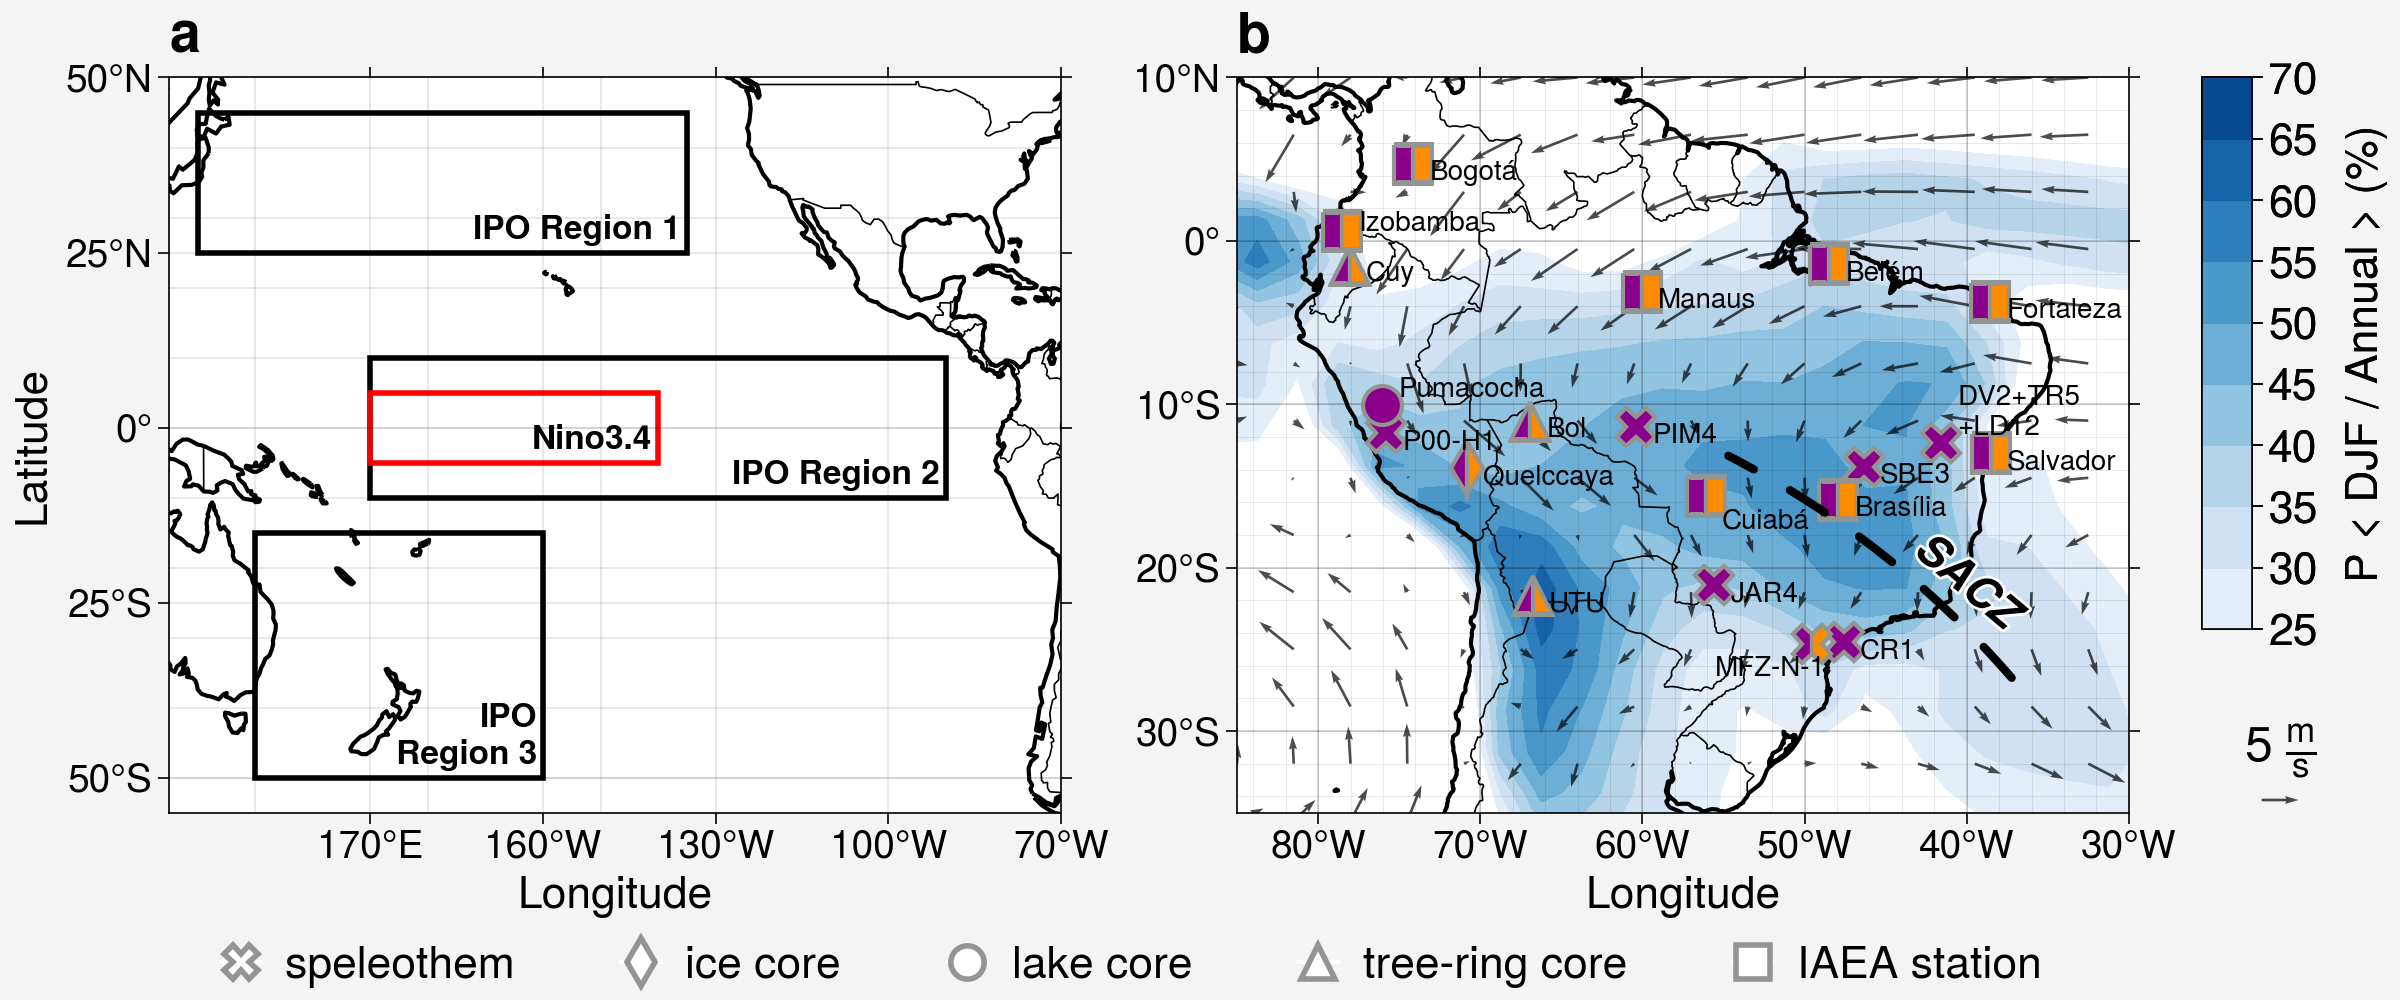

In [16]:
# Fig for reviewers: ocean modes, records and low level flow. 
# Need to redefine central longitude, reorganize all the records. 
# global styling for plots
plot.rc['abc.size'] = 20
plt.rc('legend',fontsize=16)
# Plotting proxies used in IPO/ENSO analysis and GNIP station locations with background contouring and vectors
proj = ccrs.PlateCarree(central_longitude=180)
fig, (ax_pac, ax_sam) = plot.subplots((1,2), proj=proj, sharey='labels', figsize=(12, 5))

# For Pac Ocean
ax_pac.set_extent([-45+180,30+180,50,-55], crs=ccrs.PlateCarree())  #deg east, deg north
ax_pac.set_xticks([170-360, -160, -130, -100, -70], crs=ccrs.PlateCarree()) 
ax_pac.set_yticks([-50,-25, 0, 25, 50], crs=ccrs.PlateCarree())
ax_pac.set_ylabel('Latitude', fontsize=16)
ax_pac.format(abc='a', abcloc='l', land=False, labels=False, lonlines=30, latlines=10, gridminor=False)

# For S America
ax_sam.set_extent([330,275,6,-35], crs=ccrs.PlateCarree())
# ax_sam.set_extent([330,225,15,-35], crs=ccrs.PlateCarree())
ax_sam.set_xticks([-80,-70,-60,-50,-40,-30], crs=ccrs.PlateCarree())   
ax_sam.set_yticks([-30,-20,-10,0,10], crs=ccrs.PlateCarree())
ax_sam.format(abc='a', abcloc='l', land=False, labels=False, lonlines=10, latlines=10, gridminor=True)

# Set some parameters
cmap = plt.cm.get_cmap('Blues')
# between 0 and 1, 0 for the leftmost color of the range, 1 for the rightmost, upper > lower
upper_color = 0.9
lower_color = 0.1
num_colors =  10 # len(self.data.columns)
blues_col = cmap(np.linspace(lower_color, upper_color, num_colors))
# Plot djf fraction of ann rainfall 
isos = ax_sam.contourf(lon,lat,djf_frac_avg, cmap=blues_col,levels=np.arange(25, 75, 5))
    
for axs in [ax_pac, ax_sam]:
    axs.set_aspect('auto',adjustable=None)  
    axs.coastlines(linewidth=1.5)
    axs.add_feature(cf.BORDERS)  
    lon_fmt = LongitudeFormatter(number_format='.0f')
    lat_fmt = LatitudeFormatter(number_format='.0f')
    axs.yaxis.set_major_formatter(lat_fmt)
    axs.xaxis.set_major_formatter(lon_fmt)
    axs.tick_params(axis='both', labelsize=14, reset=True)
    axs.set_xlabel('Longitude', fontsize=16)

# -------------------------- 850 hPa Field with annotations
# ax_sam.set_title('IPO Network; 850 hPa dynamic features and wind field')
ax_sam.set_title('')
Q_l = ax_sam.quiver(lon_U[::14], lat_U[::14], u[1][::14, ::14], v[1][::14, ::14], minlength = .8, width = 0.003, transform=ccrs.PlateCarree(), alpha = 0.7)

sacz = ax_sam.annotate('SACZ',xy=(140,-21),fontsize=16,weight='bold', ha='center',va='center',style='oblique',color='k',rotation=-40)
sacz.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
ax_sam.annotate("",xy=(125, -13),xytext=(143, -27),arrowprops=dict(lw=3,arrowstyle="-",linestyle = (0,(5,5)),color='k',connectionstyle='arc3,rad=0.1'))

# -----------------------------    
# Plotting IPO, ENSO regions in the ocean
# -----------------------------    
# IPO regions
ipo1 = patches.Rectangle((-40, 25), 85, 20, fill=False, ec='k', lw=2.0)
ax_pac.add_patch(ipo1)
ipo1x, ipo1y = ipo1.get_xy()
cx = ipo1x + ipo1.get_width() - 1.
cy = ipo1y + 1 # + ipo1.get_height()/3.0
ax_pac.annotate('IPO Region 1', (cx, cy), color='k', weight='bold', fontsize=12, ha='right', va='bottom')


ipo2 = patches.Rectangle((-10, -10), 100, 20, fill=False, ec='k', lw=2.0)
ax_pac.add_patch(ipo2)
ipo2x, ipo2y = ipo2.get_xy()
cx = ipo2x + ipo2.get_width() - 1.
cy = ipo2y + 1 #+ ipo2.get_height()/3.0
ax_pac.annotate('IPO Region 2', (cx, cy), color='k', weight='bold', fontsize=12, ha='right', va='bottom')

ipo3 = patches.Rectangle((-30, -50), 50, 35, fill=False, ec='k', lw=2.0)
ax_pac.add_patch(ipo3)
ipo3x, ipo3y = ipo3.get_xy()
cx = ipo3x + ipo3.get_width() - 1.
cy = ipo3y + 1 #+ ipo3.get_height()/3.0 + 1.
ax_pac.annotate("IPO\n Region 3", (cx, cy), color='k', weight='bold', fontsize=12, ha='right', va='bottom')

# Enso3.4 region
n34 = patches.Rectangle((-10, -5), 50, 10, fill=False, ec='red', lw=2.0)
ax_pac.add_patch(n34)
n34x, n34y = n34.get_xy()
cx = n34x + n34.get_width() - 1.
cy = n34y + 1 #+ n34.get_height()/3.0
ax_pac.annotate('Nino3.4', (cx, cy), color='k', weight='bold', fontsize=12, ha='right', va='bottom')

# -----------------------------    
# Plotting continental IPO, ENSO records 
# -----------------------------    
# kwargs for plotting:
filled_marker_style_IE = dict(linestyle = 'None',
                              markeredgecolor='grey', 
                              markersize=14,
                              markeredgewidth = 1.5,
                              markerfacecolor='darkmagenta', # IPO only locations
                              markerfacecoloralt='darkorange'  # IAEA, IPO, and ENSO locations
                              )

# -------------------------- Plotting proxy records
for i,(r,lat_val,lon_val) in enumerate(zip(recs_ipo,lat_pts_ipo, lon_pts_ipo)):
    if i == 0: # 0'P00-H1'
        prx_s_f = ax_sam.plot(lon_val,lat_val-0.5, marker='X', labels = 'speleothem', fillstyle='full', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val-1.5, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i == 1: # 1'CR1'
        prx_s = ax_sam.plot(lon_val + 1,lat_val, marker='X', labels = 'speleothem', fillstyle='full', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 2, lat_val - 1, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i == 4: # 4'DV2+TR5\n+LD12'
        prx_s = ax_sam.plot(lon_val,lat_val, marker='X', labels = 'speleothem', fillstyle='full', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val + 0.5, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i > 1 and i <= 5: # 2'JAR4', 3'SBE3', 5'PIM4'
        prx_s = ax_sam.plot(lon_val,lat_val, marker='X', labels = 'speleothem', fillstyle='full', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val - 1, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i == 6: #6'MFZ' 
        prx_s = ax_sam.plot(lon_val,lat_val, marker='X', labels = 'speleothem', fillstyle='left', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val - 6, lat_val - 2, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i == 7: #7'Quelccaya' 
        prx_i = ax_sam.plot(lon_val,lat_val, marker='d', labels = 'ice core', fillstyle='left', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val - 1, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i == 8: #8 'Pumacocha'
        prx_l_f = ax_sam.plot(lon_val,lat_val, marker='o', labels = 'lake core', fillstyle='full', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val + 0.5, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i == 10: # 10'Cuy'
        prx_t = ax_sam.plot(lon_val,lat_val-1, marker='^', labels = 'tree cellulose', fillstyle='left', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val - 2, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    else: # 9'UTU', 11'Bol'
        prx_t = ax_sam.plot(lon_val,lat_val, marker='^', labels = 'tree cellulose', fillstyle='left', **filled_marker_style_IE, transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val - 1, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
# -------------------------- Plotting gnip stations
for i,(r,lat_val,lon_val) in enumerate(zip(sta_gnip,gnip_lat, gnip_lon)):
    if i == 1: # 1'Izobamba'
        gnip_t = ax_sam.plot(lon_val,lat_val+1, marker='s', labels = 'IAEA stations', fillstyle='left', **filled_marker_style_IE,transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val + 1, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    elif i == 6: # 6'Cuiaba'
        gnip_t = ax_sam.plot(lon_val,lat_val, marker='s', labels = 'IAEA stations', fillstyle='left', **filled_marker_style_IE,transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val - 2, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())
    else: # 0'Bogota', 2'Belem', 3'Manaus', 4'Fortaleza', 5'Salvador', 7'Brazilia'
        gnip_t = ax_sam.plot(lon_val,lat_val, marker='s', labels = 'IAEA stations', fillstyle='left', **filled_marker_style_IE,transform=ccrs.PlateCarree())
        txt = ax_sam.text(lon_val + 1, lat_val - 1, r, size=10, horizontalalignment='left', transform=ccrs.PlateCarree())

# LEGEND KEYS
# prx_s_k = ax_sam.plot(lon_val,lat_val, marker='X', labels = 'speleothem', fillstyle='full', **filled_marker_style_IE, transform=ccrs.PlateCarree())
# prx_i_k = 
# prx_l_f_k = 
# prx_t_k =
# gnip_t_k =

legend_elements = [Line2D([0], [0], color = 'w', markeredgecolor = 'grey', markeredgewidth = 2, marker = 'X', label='speleothem   ',  markersize=12),
                   Line2D([0], [0], color = 'w', markeredgecolor = 'grey', markeredgewidth = 2, marker='d', label='ice core   ', markersize=12),
                   Line2D([0], [0], color = 'w', markeredgecolor = 'grey', markeredgewidth = 2, marker='o', label='lake core   ', markersize=12),
                   Line2D([0], [0], color = 'w', markeredgecolor = 'grey', markeredgewidth = 2, marker='^', label='tree-ring core   ', markersize=12),
                   Line2D([0], [0], color = 'w', markeredgecolor = 'grey', markeredgewidth = 2, marker = 's', label='IAEA station   ',  markersize=12)]

#PLOT LEGEND
prx_all = prx_s_f + prx_i+prx_l_f+prx_t+gnip_t
lbls = [l.get_label() for l in prx_all]
# leg = fig.legend(prx_all, lbls, loc='bottom', ncols=5, fontsize=16, center=True, frameon=False)
fig.legend(legend_elements, handlelength=1, loc='bottom', ncols=5, fontsize=16, center=True, frameon=False)

qk_l = plt.quiverkey(Q_l,0.95, 0.2, 5, r'$5 \,\, \frac{m}{s}$', coordinates='figure', labelsep=0.1, 
                   fontproperties = {'size':18})

cbar = plt.colorbar(isos, loc='r', length=0.75, width = 0.25, align='top')#, fraction=0.032, pad=0.04)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('P < DJF / Annual > (%)',fontsize=16, labelpad = 10)

fig.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/Pac_SAm/r2r/Fig2_ipoenso_proxylocs_gpcpfrac_era5U_oceanmodes.jpg', format='JPEG', facecolor='w', dpi=300)
plt.show()
plot.rc.reset()